In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
my_data = np.genfromtxt('BCI01.csv',delimiter=',')
initial_time = my_data[0,17]
ref_counter = my_data[0,15]
time_threshhold = 1000
ref_time = initial_time

In [3]:
# my_data = my_data[7500:]
my_data.shape

(485495, 18)

In [4]:
import pandas as pd
bci_data = pd.read_csv("UI01.csv",header = None).to_numpy()

In [5]:
bci_data[0,2]

1653722047239

In [6]:
my_data[0,-1]

1653722044225.0

In [7]:
bci_data[1,2] - my_data[10000,-1]

43070.0

In [8]:
import pywt

def remove_motion_artifacts(signalnp,  wavelet='sym5', level=6, ):
    def iqr(sig):
        std = np.std(sig)
        return std

    
    for i in range(8):
        sig = signalnp[:,i]

        coeff = pywt.wavedec(sig, wavelet, level=level)
        # print(10*iqr(sig))
        thresh = 7 * iqr(sig)
        fto = 4
        coeff[:fto] = (pywt.threshold(c, thresh, mode='less', substitute=0) for c in coeff[:fto])
        coeff[:fto] = (pywt.threshold(c, -thresh, mode='greater', substitute=0) for c in coeff[:fto])
        clean_sig = pywt.waverec(coeff, wavelet, mode='smooth')

        # print(clean_sig)
        signalnp[:,i] = clean_sig[:len(sig)]

In [9]:
def draw_graph(inp):
#     x = range(inp.shape[0])
    x = range(10000)

    f, axis = plt.subplots(8)
    f.set_figheight(50)
    f.set_figwidth(15)
    for i in range(8):
        axis[i].plot(x,inp[10000:20000,i])
        axis[i].set_title(f"Channel {i+1}")
    plt.subplots_adjust(wspace=0.4, 
                        hspace=0.9)
    plt.show()    

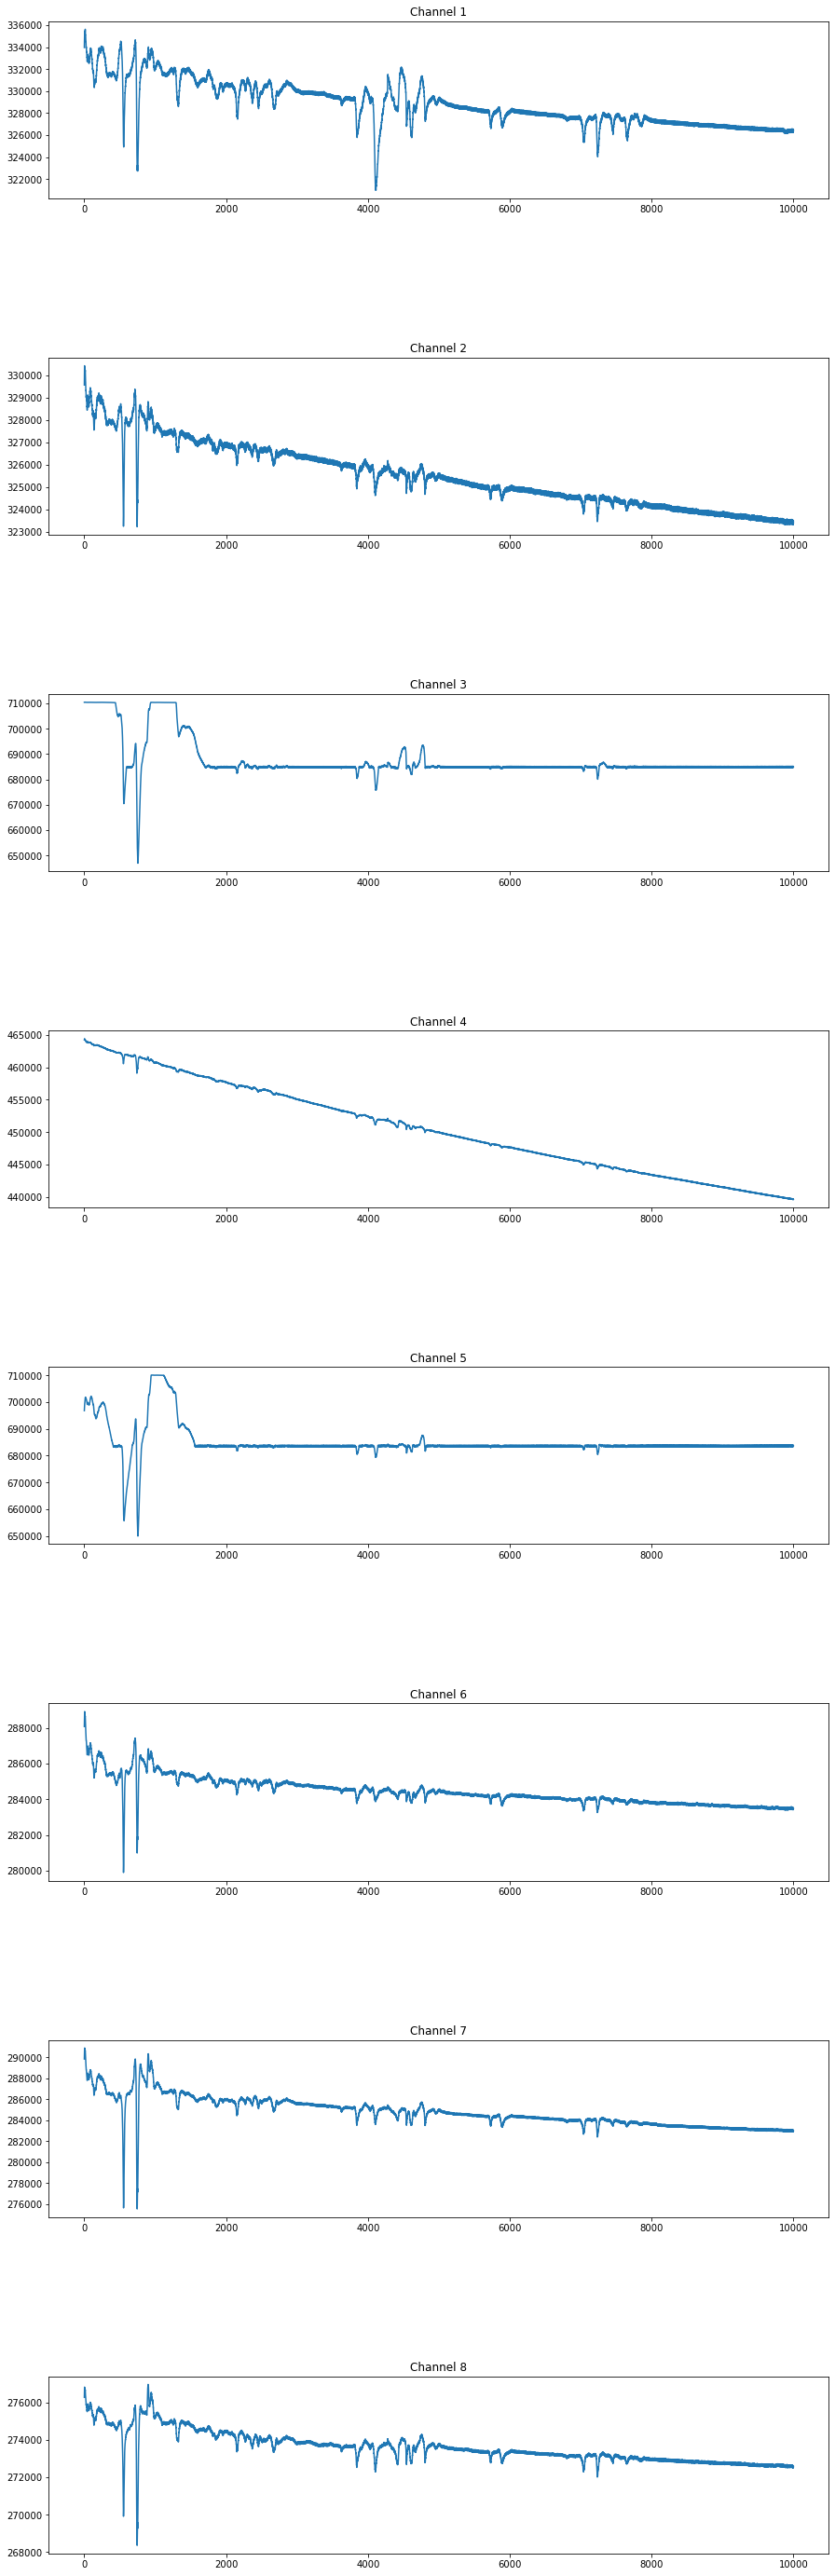

In [10]:
draw_graph(my_data)

In [11]:
from scipy.signal import butter, lfilter

from ConfigUnicorn import *


def notch_Filter(sample):
    from scipy import signal
    b_notch, a_notch = signal.iirnotch(NOTCH_FREQ, QUALITY_FACTOR, SAMPLING_FREQUENCY)
    outputSignal = signal.filtfilt(b_notch, a_notch, sample)
    b_notch, a_notch = signal.iirnotch(60, QUALITY_FACTOR, SAMPLING_FREQUENCY)
    outputSignal = signal.filtfilt(b_notch, a_notch, outputSignal)
    return outputSignal


def butter_bandpass(lowcut, highcut, fs):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(N=4, Wn=[low, high], btype='band')
    return b, a


def band_Pass_filter_raw(sample):
    b, a = butter_bandpass(.1, 60, 250)
    y = lfilter(b, a, sample)
    return y


def band_Pass_filter(sample):
    b, a = butter_bandpass(1, 10, 250)
    y = lfilter(b, a, sample)
    return y


def preprocessing_Raw(data):
    for i in range(NUMBER_OF_CHANNELS):
        y = band_Pass_filter_raw(data[:,i])
        z = notch_Filter(y)
        data[:,i] = z


def preprocessing(data, is_train):
    # Common Average Reference
    avarageSignal = np.mean(data, axis=1)
    for i in range(NUMBER_OF_CHANNELS):
        data[:,i] -= avarageSignal

    # Band_Pass_Filter
    for i in range(NUMBER_OF_CHANNELS):
        filtered_signal = band_Pass_filter(data[:,i])
        data[:,i] = filtered_signal

    # Standardization
    if is_train:
        means = []
        stds = []
        for i in range(NUMBER_OF_CHANNELS):
            mean = data[:,i].mean()
            std = data[:,i].std()
            means.append(mean)
            stds.append(std)
            data[:,i] = (data[:,i] - mean) / std
#             with open(f'./experiment/{NAME}/StandardizationValues.npy', 'wb') as f:
#                 np.save(f, np.array(means))
#                 np.save(f, np.array(stds))

    else:
        pass
#         with open('./experiment/{NAME}/StandardizationValues.npy', 'rb') as f:
#             means = np.load(f)
#             stds = np.load(f)
#         for i in range(NUMBER_OF_CHANNELS):
#             data[i] = (data[i] - means[i]) / stds[i]


In [12]:
raw_data = np.copy(my_data[:,:8])

In [13]:
# filtered_data = np.copy(raw_data)
# for i in range(NUMBER_OF_CHANNELS):
#     y = band_Pass_filter_raw(np.copy(raw_data[:,i]))
#     filtered_data[:,i] = y
# filtered_data[:7500,:] = 0   

In [14]:
# draw_graph(filtered_data)  

In [15]:
# x= range(filtered_data.shape[0])
# f, axis = plt.subplots(8)
# f.set_figheight(50)
# f.set_figwidth(15)
# print(axis.shape)
# for i in range(8):
#     axis[i].plot(x,filtered_data[:,i])
#     axis[i].set_title(f"Channel {i+1}")
# plt.subplots_adjust(wspace=0.4, 
#                     hspace=0.9)
# plt.show()    

In [16]:
notch_data = np.copy(raw_data)
for i in range(NUMBER_OF_CHANNELS):
    y = notch_Filter(np.copy(notch_data[:,i]))
    notch_data[:,i] = y

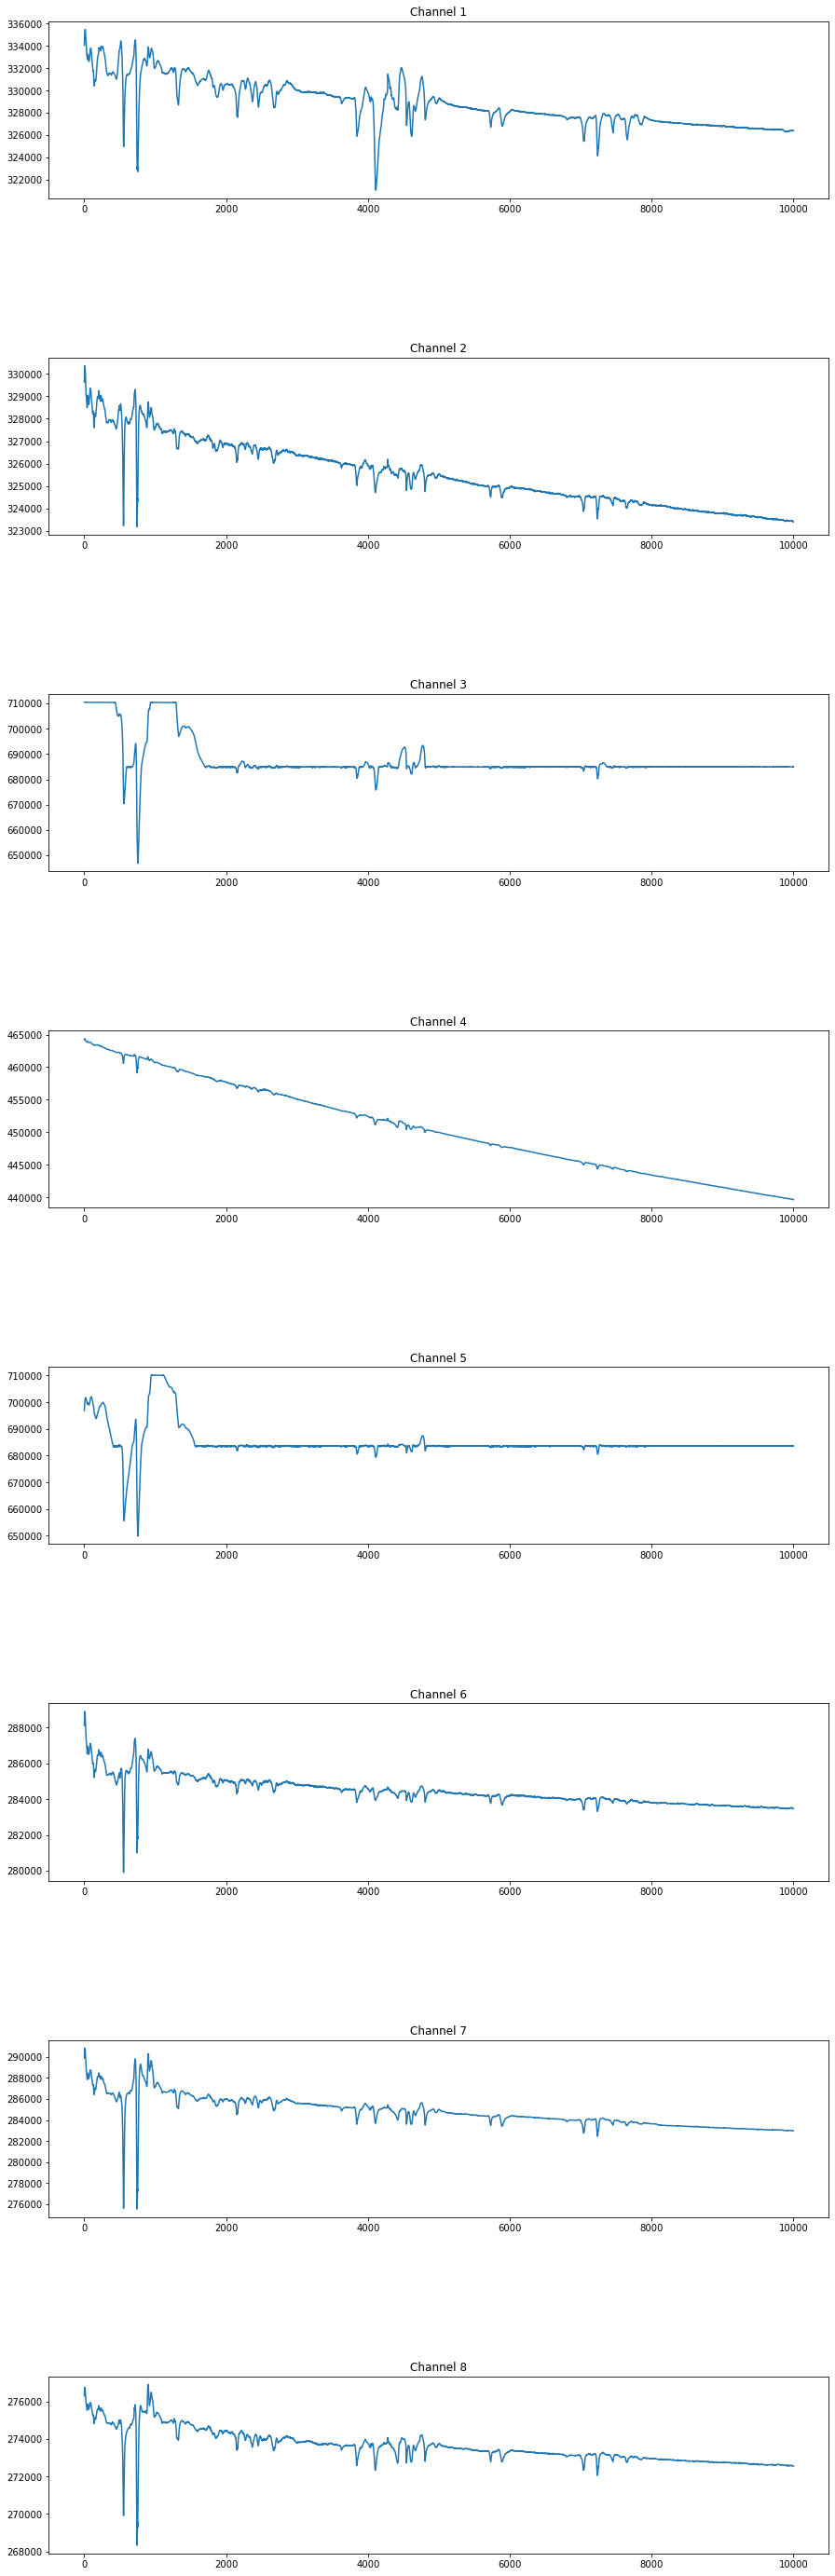

In [17]:

draw_graph(notch_data)

In [18]:
filtered_data = np.copy(notch_data)
for i in range(NUMBER_OF_CHANNELS):
    y = band_Pass_filter(np.copy(filtered_data[:,i]))
    filtered_data[:,i] = y
filtered_data[:10000,:] = 0   

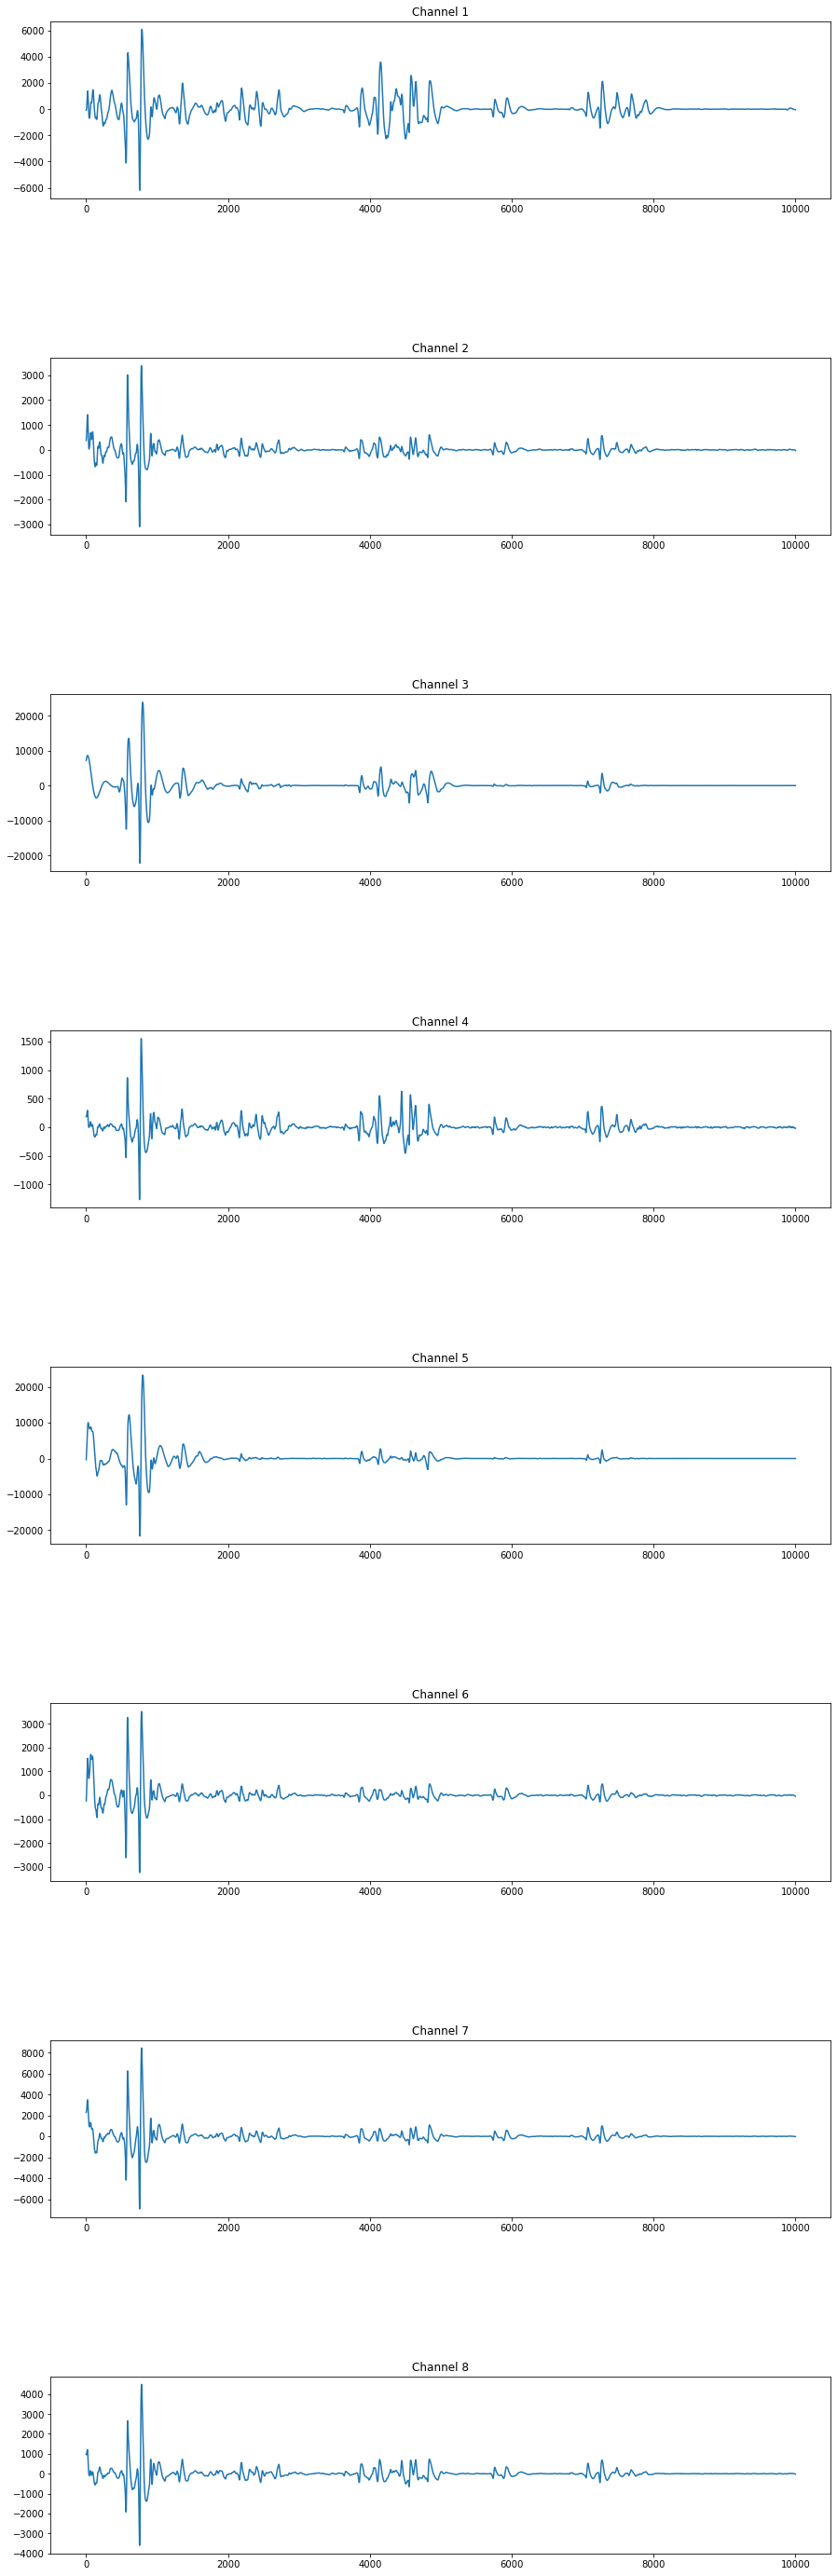

In [19]:
draw_graph(filtered_data)


In [20]:
car_data = np.copy(filtered_data)
avarageSignal = np.mean(car_data, axis=1)
print(avarageSignal.shape)
for i in range(NUMBER_OF_CHANNELS):
    car_data[:,i] -= avarageSignal

(485495,)


In [21]:
car_data.shape

(485495, 8)

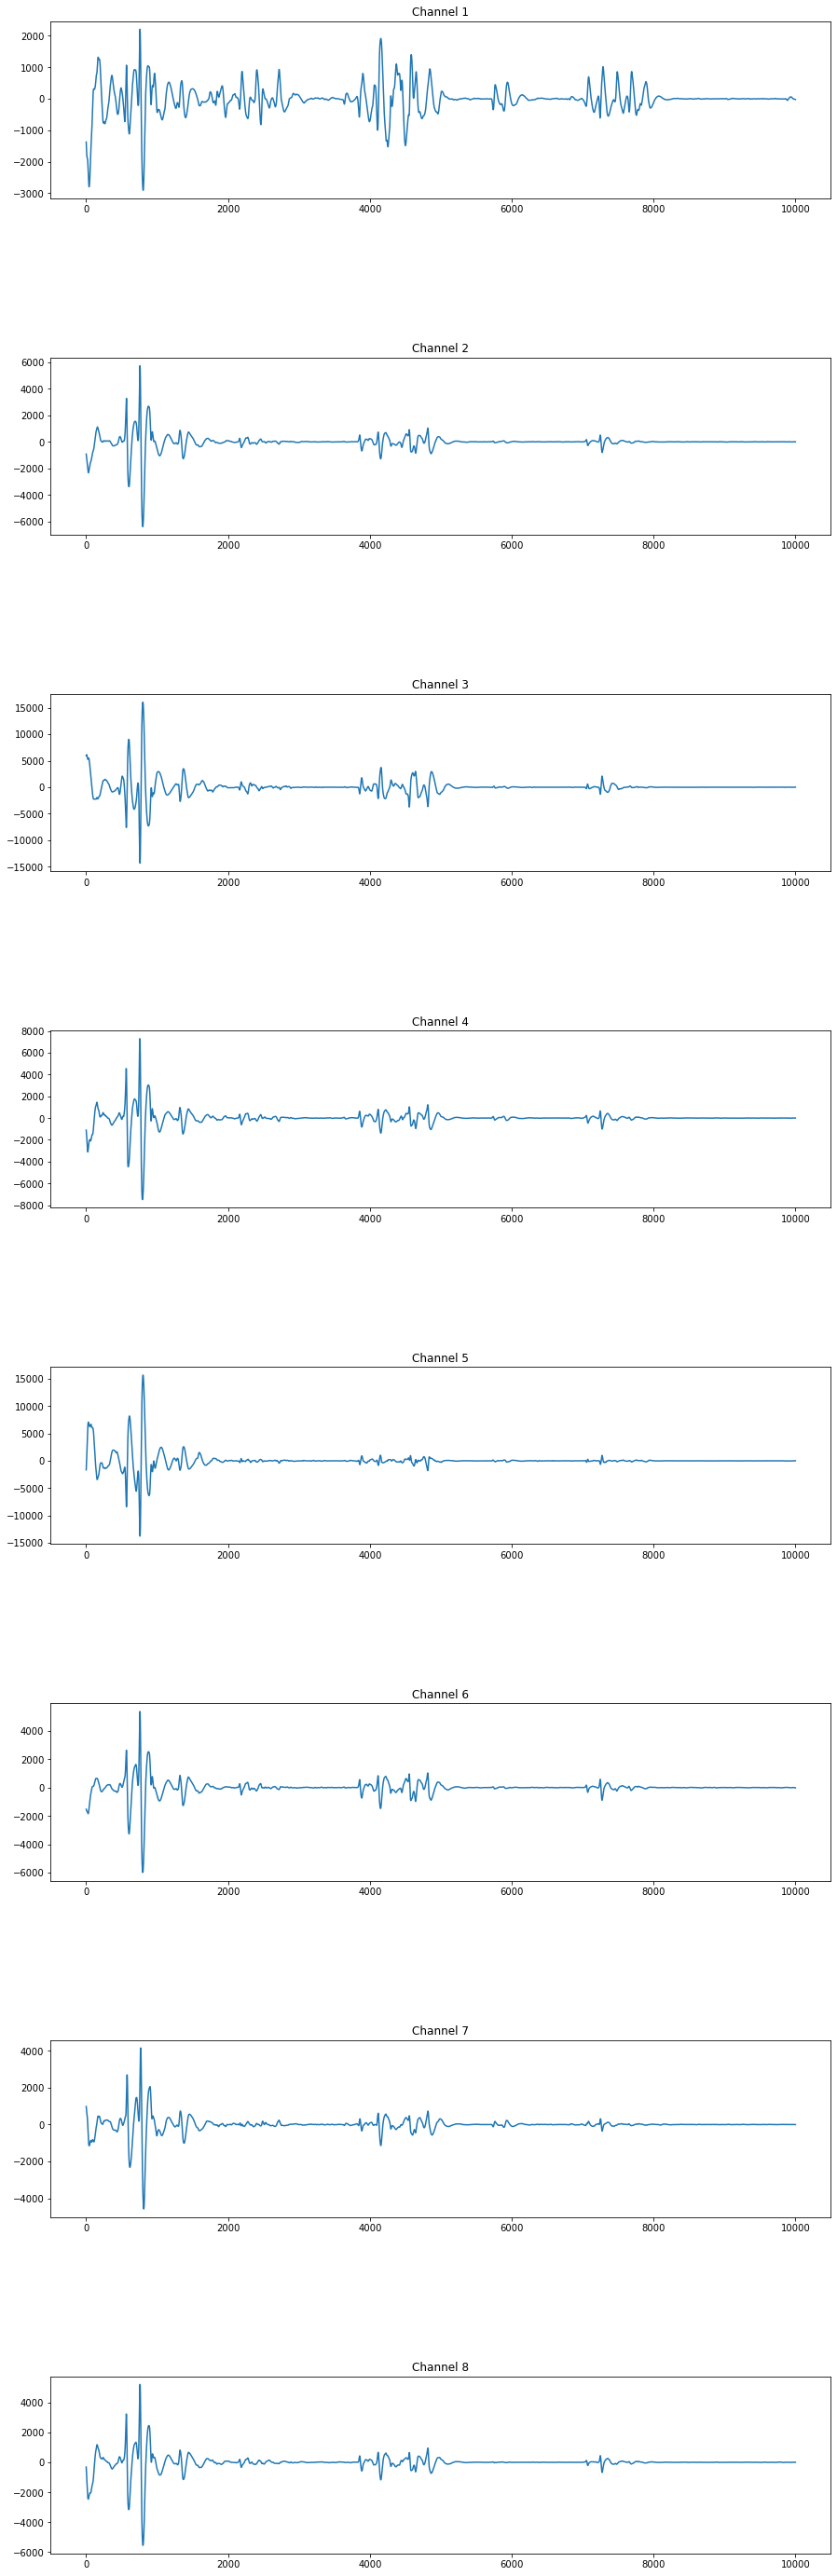

In [22]:
draw_graph(car_data)


In [23]:
# # filtered_data[:100,:] = 0
final_data = np.copy(car_data)
for i in range(NUMBER_OF_CHANNELS):
    mean = final_data[:,i].mean()
    final_data[:,i] = (final_data[:,i] - mean)
    
remove_motion_artifacts(final_data)

In [24]:
# filtered_data[:100,:] = 0
# final_data = np.copy(car_data)
# means = []
# stds = []
# for i in range(NUMBER_OF_CHANNELS):
#     mean = final_data[:,i].mean()
#     std = final_data[:,i].std()
#     means.append(mean)
#     stds.append(std)
#     final_data[:,i] = (final_data[:,i] - mean) / std

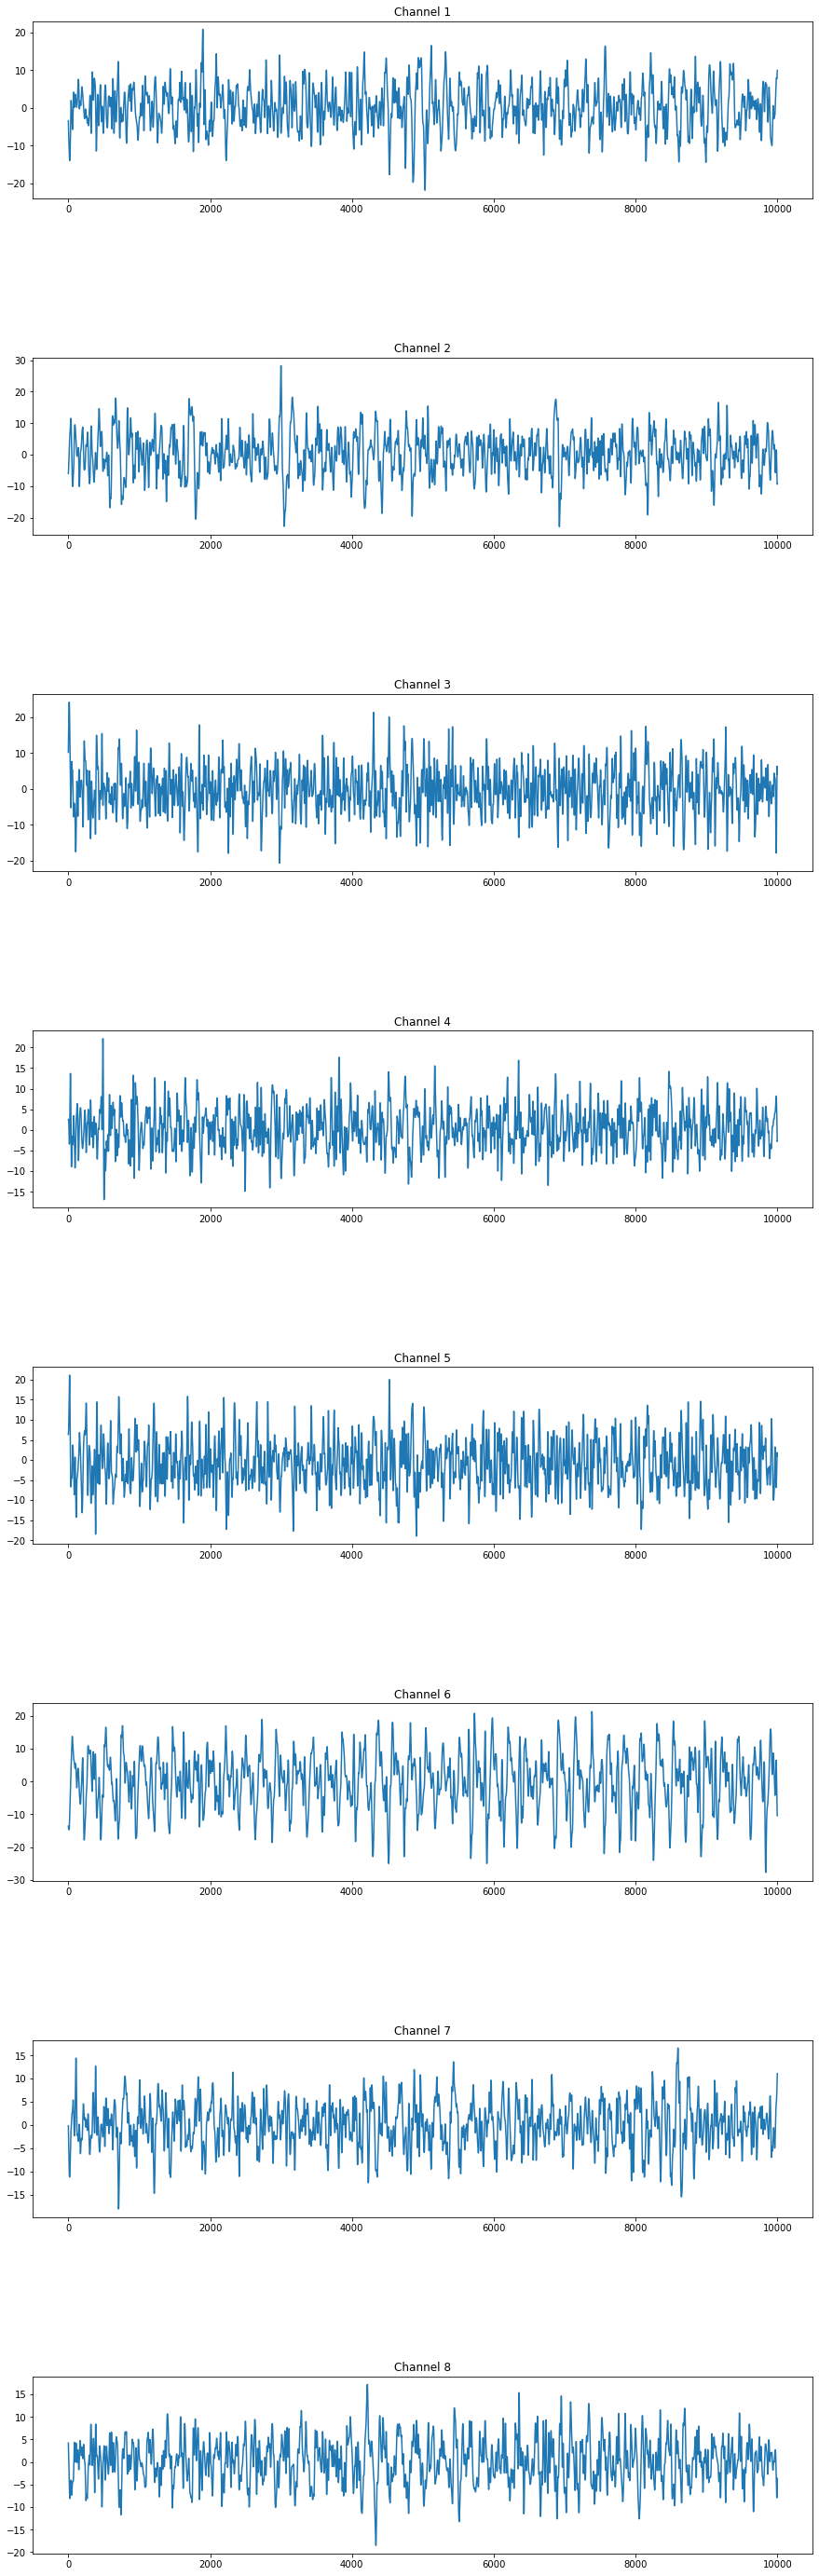

In [25]:
draw_graph(final_data[15000:])

In [26]:
final_data.shape

(485495, 8)

In [27]:
time = my_data[:,17]
code = my_data[:,15]
bci_data[-1,2]-initial_time
j = int(0)
stimuli = []
targets = []


In [28]:
time.shape

(485495,)

In [29]:
code.shape

(485495,)

In [30]:
code

array([1.00000e+00, 2.00000e+00, 3.00000e+00, ..., 4.85493e+05,
       4.85494e+05, 4.85495e+05])

In [31]:
(bci_data[-1,2])

1653723976692

In [32]:
code[-1]

485495.0

In [33]:
for i in range(bci_data.shape[0]):
    if i< bci_data.shape[0]-1:
        t = bci_data[i+1,2]
    else:
        t = int(time[-1]*2)
#     print(t)
    current_code = ref_counter + (t-ref_time)/4 - 1
    while j<final_data.shape[0]:
        if current_code <= code[j]:
            k =j
            while time[k] == time[k-1]:
                k-=1
            ref_counter = code[k]
            ref_time = time[k]
            break
        stimuli.append(bci_data[i,0])
        targets.append(bci_data[i,1])
        j+=1

In [34]:
stimuli = np.array(stimuli)
targets = np.array(targets)


In [35]:
stimuli.shape

(485495,)

In [36]:
targets.shape

(485495,)

In [37]:
stimuli[-250:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
def indeces_of_instruction(c):
    indeces = np.where(INSTRUCTION_MATRIX == c)
    row = indeces[0][0] + 4
    col = indeces[1][0] + 1
    return row, col

In [39]:
def prepare_for_model(signal, code, targeted):
    print(code)
    p300_res = np.zeros(WINDOW * NUMBER_OF_CHANNELS)
    nonp300_res = np.zeros(WINDOW * CHANNELS.shape[0])
    # if it has P300
    isP300 = np.zeros(NUMBER_OF_EPOCHS * NUMBER_OF_FLASHES, int)
    update_p300 = 0
    update_non_p300 = 0
    responses = np.zeros((NUMBER_OF_EPOCHS * NUMBER_OF_FLASHES, WINDOW * NUMBER_OF_CHANNELS), np.float32)
    epoch = 0
    current_flash_number = int(0)
    instructions = []
    current_instruction = ""
    targeted_row, targeted_col = 0, 0
    #Looping over eache entry in our signal
    for i in range(1, signal.shape[0]):
        #Checking if flashing starts
        if code[i - 1] < 0.5 < code[i]:
            if current_flash_number == 0:
                current_instruction = targeted[i]
                instructions.append(current_instruction)

                targeted_row, targeted_col = indeces_of_instruction(current_instruction)
                isP300[NUMBER_OF_FLASHES * epoch + targeted_row - 1] = 1
                isP300[NUMBER_OF_FLASHES * epoch + targeted_col - 1] = 1
            current_flash_number += 1
            rowcol = int(code[i])
#             print(i,rowcol)

            for ch in CHANNELS:
                extracted_sample = signal[i:i + WINDOW, ch]
                responses[epoch * NUMBER_OF_FLASHES + rowcol - 1][ch * WINDOW:ch * WINDOW + WINDOW] += extracted_sample
                if targeted_col == rowcol or targeted_row == rowcol:
                    p300_res[ch * WINDOW:ch * WINDOW + WINDOW] += extracted_sample
                    update_p300+=1
                else:
                    nonp300_res[ch * WINDOW:ch * WINDOW + WINDOW] += extracted_sample
                    update_non_p300+=1
            if current_flash_number == NUMBER_OF_FLASHES * NUMBER_OF_TRIALS:
                current_flash_number = 0
                epoch += 1
    responses = responses / NUMBER_OF_TRIALS
    p300_res = p300_res / (2 * NUMBER_OF_TRIALS * NUMBER_OF_EPOCHS)
    nonp300_res = nonp300_res / (4 * NUMBER_OF_TRIALS * NUMBER_OF_EPOCHS)
    print(update_p300,update_non_p300)
    return responses, isP300, np.array(instructions), p300_res, nonp300_res


In [40]:
responses,isP300,targets,p300, nonp300 =  prepare_for_model(final_data,stimuli,targets)

[0 0 0 ... 0 0 0]
12000 24000


In [41]:
responses.shape

(300, 2000)

In [42]:
isP300.shape

(300,)

In [43]:
targets.shape

(50,)

In [44]:
p300.shape

(2000,)

In [45]:
nonp300.shape

(2000,)

In [46]:
def graphDrawer(arr, arr2):
    
    plt.figure(figsize=(15,15))
    x_axis = np.array(range(WINDOW*CHANNELS.shape[0])) / SAMPLING_FREQUENCY
    plt.plot(x_axis, arr, color='#188038', label='P300')
    plt.plot(x_axis, arr2, color='#A1282C', label='Non-P300')

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()


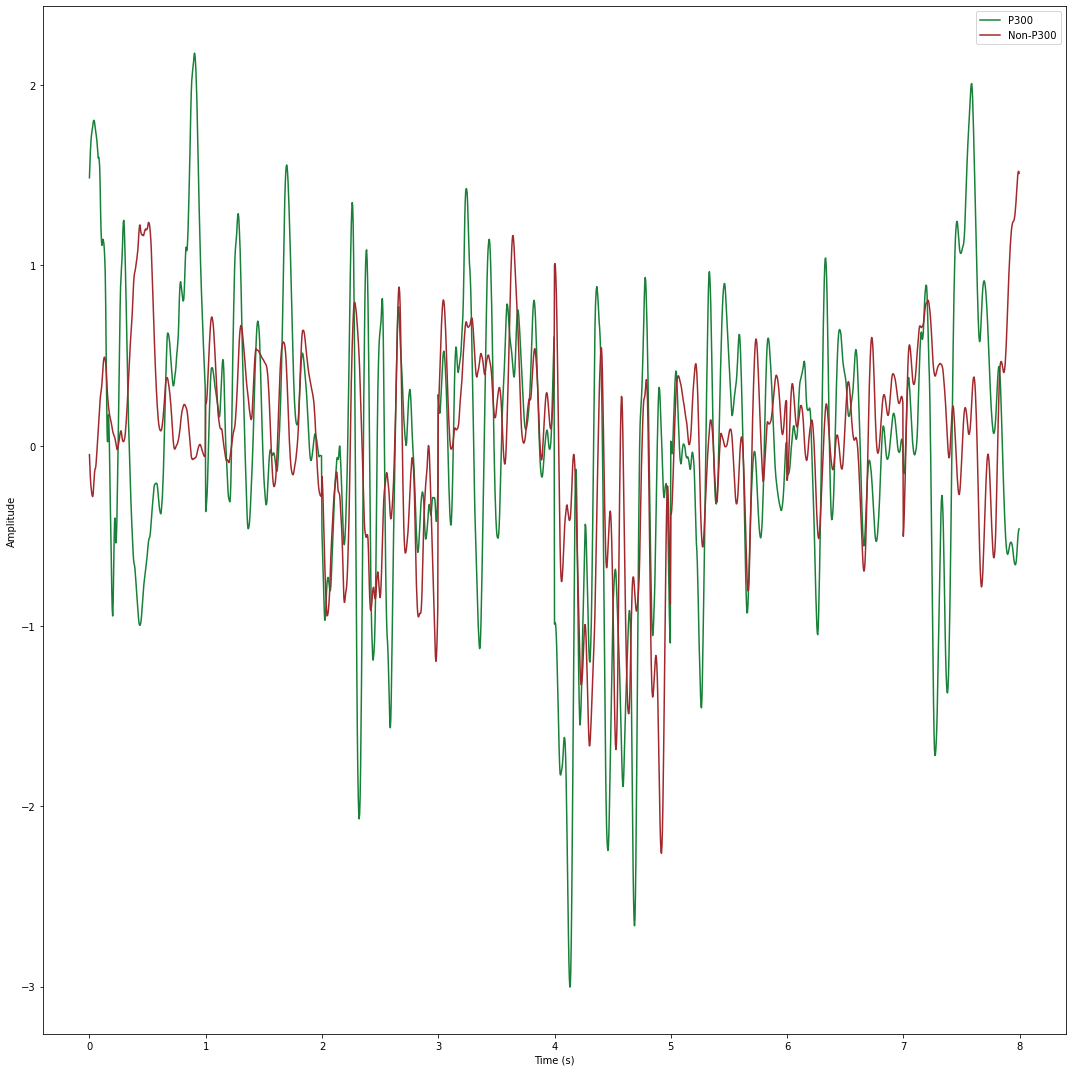

In [47]:
graphDrawer(p300,nonp300)

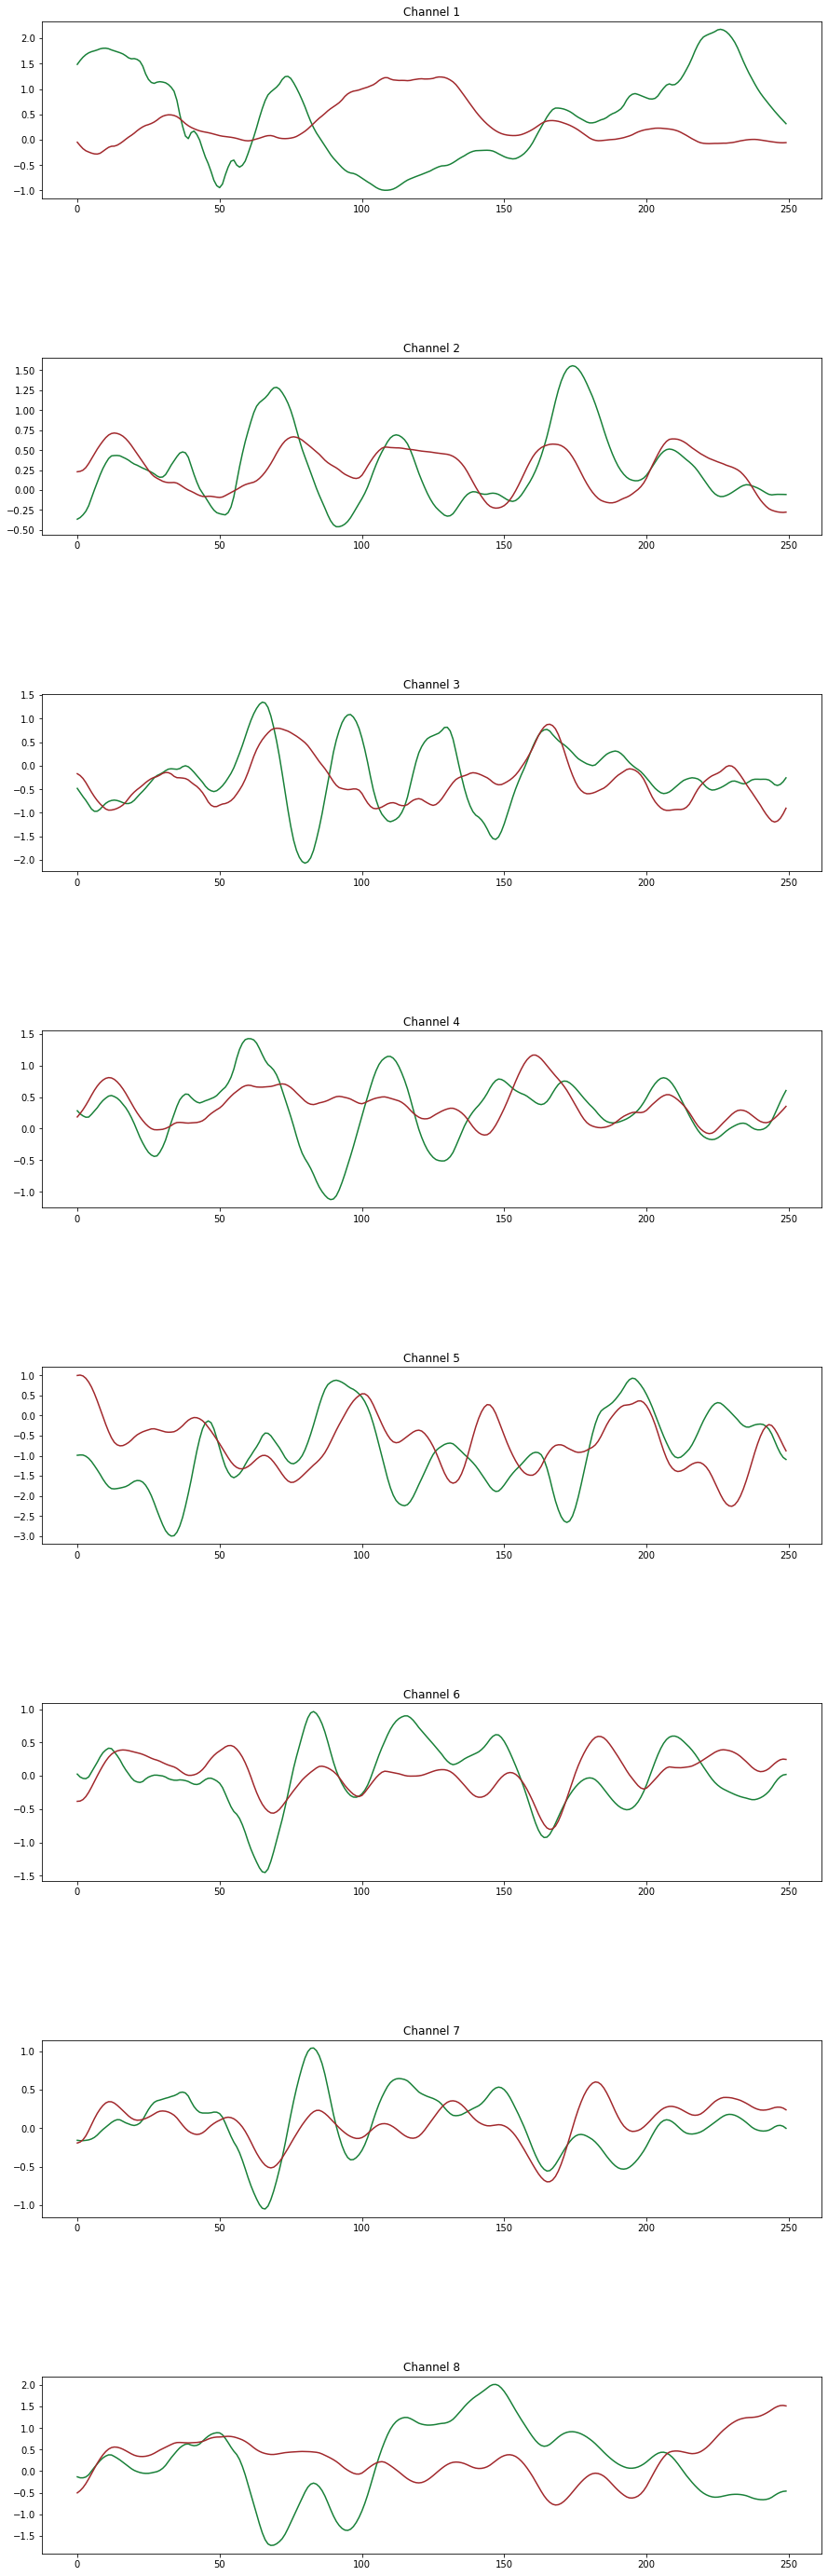

In [48]:
x_axis = range(WINDOW)
f, axis = plt.subplots(8)
f.set_figheight(50)
f.set_figwidth(15)
for i in range(8):
    axis[i].plot(x_axis, p300[WINDOW*i:WINDOW*i+WINDOW], color='#188038', label='P300')
    axis[i].plot(x_axis, nonp300[WINDOW*i:WINDOW*i+WINDOW], color='#A1282C', label='Non-P300')

#     axis[i].xlabel('Time (s)')
#     axis[i].ylabel('Amplitude')
    axis[i].set_title(f"Channel {i+1}")
#     plt.legend()
#     plt.tight_layout()
    
#     axis[i].plot(x,responses[WINDOW*i,WINDOW*i+WINDOW])
#     axis[i].set_title(f"Channel {i+1}")
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.9)
plt.show()   

In [49]:
from sklearn.model_selection import train_test_split


NUMBER_OF_SAMPLES=2000
#4*WINDOW:4*WINDOW+WINDOW
CHANNEL_NO =0
responses.shape

(300, 2000)

In [50]:
each_epoch = np.reshape(responses[:,CHANNEL_NO*NUMBER_OF_SAMPLES:CHANNEL_NO*NUMBER_OF_SAMPLES+NUMBER_OF_SAMPLES],(NUMBER_OF_EPOCHS,int(responses.shape[0]/NUMBER_OF_EPOCHS),NUMBER_OF_SAMPLES))
each_epoch.shape

(50, 6, 2000)

In [51]:
responses[6]

array([-1.3447492 , -1.4147103 , -1.45032   , ..., -0.02176642,
        0.0327604 ,  0.10409907], dtype=float32)

In [52]:
each_epoch[1][0]

array([-1.3447492 , -1.4147103 , -1.45032   , ..., -0.02176642,
        0.0327604 ,  0.10409907], dtype=float32)

In [53]:
isp300_per_epoch = np.reshape(isP300,(NUMBER_OF_EPOCHS,int(isP300.shape[0]/NUMBER_OF_EPOCHS)))
isp300_per_epoch.shape

(50, 6)

In [54]:
result = []
result.append(list(targets))
result.append(list(isp300_per_epoch))
result = np.array(result,dtype=object).T
# result

In [55]:
test_size =0.2

x_train, x_test, y_train, y_test = train_test_split(each_epoch, result, test_size = 0.2)

train_epoch = int(len(x_train))
test_epoch = int(len(x_test))

train = np.reshape(x_train,(train_epoch*6,NUMBER_OF_SAMPLES))
test = np.reshape(x_test,(test_epoch*6,NUMBER_OF_SAMPLES))

train_res = np.reshape(np.stack(y_train[:,1]),6*train_epoch)
test_res = np.reshape(np.stack(y_test[:,1]),6*test_epoch)

train_targets = y_train[:,0]
test_targets = y_test[:,0]

In [56]:
from sklearn import svm
X=responses[:,:]
X.shape

(300, 2000)

In [57]:
def instruction_accuracy(X, characters, clf, prob_func=None):
    if prob_func is None:
        prob_func = clf.decision_function
    correct_predictions_count = 0
    for i in range(len(characters)):
        segment = X[i * NUMBER_OF_FLASHES:i * NUMBER_OF_FLASHES + NUMBER_OF_FLASHES]
        score = prob_func(segment)
        row = np.argmax(score[3:]) + 4
        col = np.argmax(score[:3]) + 1
#         print(row -4)
        predicted_char = INSTRUCTION_MATRIX[row - 4][col - 1]
        target_char = characters[i]
        if target_char == predicted_char:
            correct_predictions_count += 1
    return correct_predictions_count / len(characters)

In [58]:
print("Training")
svc_balanced = svm.SVC(kernel='linear', probability=True)
svc_balanced.fit(train, train_res)
print("Score on train data SVM Linear balanced: {}".format(svc_balanced.score(train, train_res)))
print("Score on test data SVM Linear balanced: {}".format(svc_balanced.score(test, test_res)))
print("______________________________")
print("Train Character accuracy", instruction_accuracy(train, train_targets, svc_balanced)*100, "%")
print("______________________________")
print("Test Character accuracy", instruction_accuracy(test,test_targets, svc_balanced)*100, "%")
print("______________________________")


Training
Score on train data SVM Linear balanced: 1.0
Score on test data SVM Linear balanced: 0.7666666666666667
______________________________
Train Character accuracy 100.0 %
______________________________
Test Character accuracy 60.0 %
______________________________


In [59]:
print("Training")
svc_balanced = svm.SVC(kernel='rbf', probability=True)
svc_balanced.fit(train, train_res)
print("Score on train data SVM RBF balanced: {}".format(svc_balanced.score(train, train_res)))
print("Score on test data SVM RBF balanced: {}".format(svc_balanced.score(test, test_res)))
print("______________________________")
print("Train Character accuracy", instruction_accuracy(train, train_targets, svc_balanced)*100, "%")
print("______________________________")
print("Test Character accuracy", instruction_accuracy(test,test_targets, svc_balanced)*100, "%")
print("______________________________")


Training
Score on train data SVM RBF balanced: 0.8875
Score on test data SVM RBF balanced: 0.65
______________________________
Train Character accuracy 97.5 %
______________________________
Test Character accuracy 50.0 %
______________________________


In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
print("Training LDA blalanced")
lda_balanced = LinearDiscriminantAnalysis()
lda_balanced.fit(train, train_res)
print("Score on train data LDA balanced: {}".format(lda_balanced.score(train, train_res)))
print("Score on test data LDA balanced: {}".format(lda_balanced.score(test, test_res)))
print("______________________________")
print("Train Character accuracy", instruction_accuracy(train, train_targets, lda_balanced)*100, "%")
print("______________________________")
print("Test Character accuracy", instruction_accuracy(test,test_targets, svc_balanced)*100, "%")
print("______________________________")


Training LDA blalanced
Score on train data LDA balanced: 1.0
Score on test data LDA balanced: 0.65
______________________________
Train Character accuracy 100.0 %
______________________________
Test Character accuracy 50.0 %
______________________________


In [61]:
def test_model_lda(rd,NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result):
#     #4*WINDOW:4*WINDOW+WINDOW
#     CHANNEL_NO =0
#     each_epoch = np.reshape(responses[:,CHANNEL_NO*NUMBER_OF_SAMPLES:CHANNEL_NO*NUMBER_OF_SAMPLES+NUMBER_OF_SAMPLES],(NUMBER_OF_EPOCHS,int(responses.shape[0]/NUMBER_OF_EPOCHS),NUMBER_OF_SAMPLES))
#     isp300_per_epoch = np.reshape(isP300,(NUMBER_OF_EPOCHS,int(isP300.shape[0]/NUMBER_OF_EPOCHS)))
#     result = []
#     result.append(list(targets))
#     result.append(list(isp300_per_epoch))
#     result = np.array(result,dtype=object).T
#     # result
    x_train, x_test, y_train, y_test = train_test_split(each_epoch, result, test_size = 0.2,random_state=rd)

    train = np.reshape(x_train,(train_epoch*6,NUMBER_OF_SAMPLES))
    test = np.reshape(x_test,(test_epoch*6,NUMBER_OF_SAMPLES))

    train_res = np.reshape(np.stack(y_train[:,1]),6*train_epoch)
    test_res = np.reshape(np.stack(y_test[:,1]),6*test_epoch)

    train_targets = y_train[:,0]
    test_targets = y_test[:,0]

    lda_balanced = LinearDiscriminantAnalysis()
    lda_balanced.fit(train, train_res)
    target_acc = instruction_accuracy(test,test_targets, lda_balanced)*100
    return target_acc


In [62]:
def test_model_rbf(rd,NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result):
#     #4*WINDOW:4*WINDOW+WINDOW
#     CHANNEL_NO =0
#     each_epoch = np.reshape(responses[:,CHANNEL_NO*NUMBER_OF_SAMPLES:CHANNEL_NO*NUMBER_OF_SAMPLES+NUMBER_OF_SAMPLES],(NUMBER_OF_EPOCHS,int(responses.shape[0]/NUMBER_OF_EPOCHS),NUMBER_OF_SAMPLES))
#     isp300_per_epoch = np.reshape(isP300,(NUMBER_OF_EPOCHS,int(isP300.shape[0]/NUMBER_OF_EPOCHS)))
#     result = []
#     result.append(list(targets))
#     result.append(list(isp300_per_epoch))
#     result = np.array(result,dtype=object).T
#     # result
    x_train, x_test, y_train, y_test = train_test_split(each_epoch, result, test_size = 0.2,random_state=rd)

    train = np.reshape(x_train,(train_epoch*6,NUMBER_OF_SAMPLES))
    test = np.reshape(x_test,(test_epoch*6,NUMBER_OF_SAMPLES))

    train_res = np.reshape(np.stack(y_train[:,1]),6*train_epoch)
    test_res = np.reshape(np.stack(y_test[:,1]),6*test_epoch)

    train_targets = y_train[:,0]
    test_targets = y_test[:,0]

    svc_balanced = svm.SVC(kernel='rbf', probability=True)
    svc_balanced.fit(train, train_res)
    target_acc = instruction_accuracy(test,test_targets, svc_balanced)*100
    return target_acc


In [63]:
def test_model_linear(rd,NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result):
#     #4*WINDOW:4*WINDOW+WINDOW
#     CHANNEL_NO =0
#     each_epoch = np.reshape(responses[:,CHANNEL_NO*NUMBER_OF_SAMPLES:CHANNEL_NO*NUMBER_OF_SAMPLES+NUMBER_OF_SAMPLES],(NUMBER_OF_EPOCHS,int(responses.shape[0]/NUMBER_OF_EPOCHS),NUMBER_OF_SAMPLES))
#     isp300_per_epoch = np.reshape(isP300,(NUMBER_OF_EPOCHS,int(isP300.shape[0]/NUMBER_OF_EPOCHS)))
#     result = []
#     result.append(list(targets))
#     result.append(list(isp300_per_epoch))
#     result = np.array(result,dtype=object).T
#     # result
    x_train, x_test, y_train, y_test = train_test_split(each_epoch, result, test_size = 0.2,random_state=rd)

    train = np.reshape(x_train,(train_epoch*6,NUMBER_OF_SAMPLES))
    test = np.reshape(x_test,(test_epoch*6,NUMBER_OF_SAMPLES))

    train_res = np.reshape(np.stack(y_train[:,1]),6*train_epoch)
    test_res = np.reshape(np.stack(y_test[:,1]),6*test_epoch)

    train_targets = y_train[:,0]
    test_targets = y_test[:,0]

    svc_balanced = svm.SVC(kernel='linear', probability=True)
    svc_balanced.fit(train, train_res)
    target_acc = instruction_accuracy(test,test_targets, svc_balanced)*100
    return target_acc


In [64]:
acc_of_models = np.array([])
x = 0
for i in range(1,501):
    acc_of_models = np.append(acc_of_models,test_model_linear(int(i),NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result))

print("Mean",acc_of_models.mean())
print("STD",acc_of_models.std())

Mean 60.18
STD 14.743391740030514


In [65]:
acc_of_models = np.array([])
x = 0
for i in range(1,501):
    acc_of_models = np.append(acc_of_models,test_model_lda(int(i),NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result))
    

print("Mean",acc_of_models.mean())
print("STD",acc_of_models.std())

Mean 43.12
STD 15.448805779088557


In [66]:
acc_of_models = np.array([])
x = 0
for i in range(1,501):
    acc_of_models = np.append(acc_of_models,test_model_rbf(int(i),NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result))
    

print("Mean",acc_of_models.mean())
print("STD",acc_of_models.std())

Mean 48.18
STD 15.221287724762318


In [67]:
from sklearn.model_selection import train_test_split


NUMBER_OF_SAMPLES=2000
#4*WINDOW:4*WINDOW+WINDOW
CHANNEL_NO =0
responses.shape

(300, 2000)

In [68]:
each_epoch = np.reshape(responses[:,CHANNEL_NO*NUMBER_OF_SAMPLES:CHANNEL_NO*NUMBER_OF_SAMPLES+NUMBER_OF_SAMPLES],(NUMBER_OF_EPOCHS,int(responses.shape[0]/NUMBER_OF_EPOCHS),NUMBER_OF_SAMPLES))
each_epoch.shape

(50, 6, 2000)

In [69]:
isp300_per_epoch = np.reshape(isP300,(NUMBER_OF_EPOCHS,int(isP300.shape[0]/NUMBER_OF_EPOCHS)))
isp300_per_epoch.shape

(50, 6)

In [70]:
result = []
result.append(list(targets))
result.append(list(isp300_per_epoch))
result = np.array(result,dtype=object).T
# result

In [71]:
x_train, x_test, y_train, y_test = train_test_split(each_epoch, result, test_size = 0.2)

train = np.reshape(x_train,(train_epoch*6,NUMBER_OF_SAMPLES))
test = np.reshape(x_test,(test_epoch*6,NUMBER_OF_SAMPLES))

train_res = np.reshape(np.stack(y_train[:,1]),6*train_epoch)
test_res = np.reshape(np.stack(y_test[:,1]),6*test_epoch)

train_targets = y_train[:,0]
test_targets = y_test[:,0]

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)


In [73]:
from sklearn.decomposition import PCA
NUMBER_OF_DIM = 0.99
pca = PCA(n_components=0.999)
samples_no = NUMBER_OF_DIM

pca.fit(train)
train =  pca.transform(train)
test = pca.transform(test)

In [74]:
from sklearn import svm
X=responses[:,:]
X.shape

(300, 2000)

In [75]:
print("Training")
svc_balanced = svm.SVC(kernel='linear', probability=True)
svc_balanced.fit(train, train_res)
print("Score on train data SVM Linear balanced: {}".format(svc_balanced.score(train, train_res)))
print("Score on test data SVM Linear balanced: {}".format(svc_balanced.score(test, test_res)))
print("______________________________")
print("Train Character accuracy", instruction_accuracy(train, train_targets, svc_balanced)*100, "%")
print("______________________________")
print("Test Character accuracy", instruction_accuracy(test,test_targets, svc_balanced)*100, "%")
print("______________________________")


Training
Score on train data SVM Linear balanced: 1.0
Score on test data SVM Linear balanced: 0.85
______________________________
Train Character accuracy 100.0 %
______________________________
Test Character accuracy 70.0 %
______________________________


In [76]:
print("Training")
svc_balanced = svm.SVC(kernel='rbf', probability=True)
svc_balanced.fit(train, train_res)
print("Score on train data SVM RBF balanced: {}".format(svc_balanced.score(train, train_res)))
print("Score on test data SVM RBF balanced: {}".format(svc_balanced.score(test, test_res)))
print("______________________________")
print("Train Character accuracy", instruction_accuracy(train, train_targets, svc_balanced)*100, "%")
print("______________________________")
print("Test Character accuracy", instruction_accuracy(test,test_targets, svc_balanced)*100, "%")
print("______________________________")


Training
Score on train data SVM RBF balanced: 0.9375
Score on test data SVM RBF balanced: 0.7666666666666667
______________________________
Train Character accuracy 97.5 %
______________________________
Test Character accuracy 70.0 %
______________________________


In [77]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
print("Training LDA blalanced")
lda_balanced = LinearDiscriminantAnalysis()
lda_balanced.fit(train, train_res)
print("Score on train data LDA balanced: {}".format(lda_balanced.score(train, train_res)))
print("Score on test data LDA balanced: {}".format(lda_balanced.score(test, test_res)))
print("______________________________")
print("Train Character accuracy", instruction_accuracy(train, train_targets, lda_balanced)*100, "%")
print("______________________________")
print("Test Character accuracy", instruction_accuracy(test,test_targets, lda_balanced)*100, "%")
print("______________________________")


Training LDA blalanced
Score on train data LDA balanced: 1.0
Score on test data LDA balanced: 0.8833333333333333
______________________________
Train Character accuracy 100.0 %
______________________________
Test Character accuracy 70.0 %
______________________________


In [78]:
def test_model_linear_pca(rd,NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result):
#     #4*WINDOW:4*WINDOW+WINDOW
#     CHANNEL_NO =0
#     each_epoch = np.reshape(responses[:,CHANNEL_NO*NUMBER_OF_SAMPLES:CHANNEL_NO*NUMBER_OF_SAMPLES+NUMBER_OF_SAMPLES],(NUMBER_OF_EPOCHS,int(responses.shape[0]/NUMBER_OF_EPOCHS),NUMBER_OF_SAMPLES))
#     isp300_per_epoch = np.reshape(isP300,(NUMBER_OF_EPOCHS,int(isP300.shape[0]/NUMBER_OF_EPOCHS)))
#     result = []
#     result.append(list(targets))
#     result.append(list(isp300_per_epoch))
#     result = np.array(result,dtype=object).T
#     # result
    x_train, x_test, y_train, y_test = train_test_split(each_epoch, result, test_size = 0.2,random_state=rd)

    train = np.reshape(x_train,(40*6,NUMBER_OF_SAMPLES))
    test = np.reshape(x_test,(10*6,NUMBER_OF_SAMPLES))

    train_res = np.reshape(np.stack(y_train[:,1]),6*40)
    test_res = np.reshape(np.stack(y_test[:,1]),6*10)

    train_targets = y_train[:,0]
    test_targets = y_test[:,0]

    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()

    scaler.fit(train)

    train = scaler.transform(train)
    test = scaler.transform(test)

    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=0.999)

    pca.fit(train)
    train =  pca.transform(train)
    test = pca.transform(test)
    svc_balanced = svm.SVC(kernel='linear', probability=True)
    svc_balanced.fit(train, train_res)

    target_acc = instruction_accuracy(test,test_targets, svc_balanced)*100

    return target_acc


In [79]:
# x = 0
# for i in range(1,501):
#     x+= test_model(int(i),NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result)
# x/=500

In [80]:
# x

In [81]:
def test_model_rbf_pca(rd,NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result):
#     #4*WINDOW:4*WINDOW+WINDOW
#     CHANNEL_NO =0
#     each_epoch = np.reshape(responses[:,CHANNEL_NO*NUMBER_OF_SAMPLES:CHANNEL_NO*NUMBER_OF_SAMPLES+NUMBER_OF_SAMPLES],(NUMBER_OF_EPOCHS,int(responses.shape[0]/NUMBER_OF_EPOCHS),NUMBER_OF_SAMPLES))
#     isp300_per_epoch = np.reshape(isP300,(NUMBER_OF_EPOCHS,int(isP300.shape[0]/NUMBER_OF_EPOCHS)))
#     result = []
#     result.append(list(targets))
#     result.append(list(isp300_per_epoch))
#     result = np.array(result,dtype=object).T
#     # result
    x_train, x_test, y_train, y_test = train_test_split(each_epoch, result, test_size = 0.2,random_state=rd)

    train = np.reshape(x_train,(40*6,NUMBER_OF_SAMPLES))
    test = np.reshape(x_test,(10*6,NUMBER_OF_SAMPLES))

    train_res = np.reshape(np.stack(y_train[:,1]),6*40)
    test_res = np.reshape(np.stack(y_test[:,1]),6*10)

    train_targets = y_train[:,0]
    test_targets = y_test[:,0]

    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()

    scaler.fit(train)

    train = scaler.transform(train)
    test = scaler.transform(test)

    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=0.999)

    pca.fit(train)
    train =  pca.transform(train)
    test = pca.transform(test)
    svc_balanced = svm.SVC(kernel='rbf', probability=True)
    svc_balanced.fit(train, train_res)

    target_acc = instruction_accuracy(test,test_targets, svc_balanced)*100

    return target_acc


In [82]:
def test_model_lda_pca(rd,NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result):
#     #4*WINDOW:4*WINDOW+WINDOW
#     CHANNEL_NO =0
#     each_epoch = np.reshape(responses[:,CHANNEL_NO*NUMBER_OF_SAMPLES:CHANNEL_NO*NUMBER_OF_SAMPLES+NUMBER_OF_SAMPLES],(NUMBER_OF_EPOCHS,int(responses.shape[0]/NUMBER_OF_EPOCHS),NUMBER_OF_SAMPLES))
#     isp300_per_epoch = np.reshape(isP300,(NUMBER_OF_EPOCHS,int(isP300.shape[0]/NUMBER_OF_EPOCHS)))
#     result = []
#     result.append(list(targets))
#     result.append(list(isp300_per_epoch))
#     result = np.array(result,dtype=object).T
#     # result
    x_train, x_test, y_train, y_test = train_test_split(each_epoch, result, test_size = 0.2,random_state=rd)

    train = np.reshape(x_train,(40*6,NUMBER_OF_SAMPLES))
    test = np.reshape(x_test,(10*6,NUMBER_OF_SAMPLES))

    train_res = np.reshape(np.stack(y_train[:,1]),6*40)
    test_res = np.reshape(np.stack(y_test[:,1]),6*10)

    train_targets = y_train[:,0]
    test_targets = y_test[:,0]

    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()

    scaler.fit(train)

    train = scaler.transform(train)
    test = scaler.transform(test)

    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=0.999)

    pca.fit(train)
    train =  pca.transform(train)
    test = pca.transform(test)
    lda_balanced = LinearDiscriminantAnalysis()
    lda_balanced.fit(train, train_res)

    target_acc = instruction_accuracy(test,test_targets, lda_balanced)*100

    return target_acc


In [83]:
acc_of_models = np.array([])
x = 0
for i in range(1,501):
    acc_of_models = np.append(acc_of_models,test_model_linear_pca(int(i),NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result))

print("Mean",acc_of_models.mean())
print("STD",acc_of_models.std())

Mean 66.28
STD 14.413937699324222


In [84]:
acc_of_models = np.array([])
x = 0
for i in range(1,501):
    acc_of_models = np.append(acc_of_models,test_model_lda_pca(int(i),NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result))
    

print("Mean",acc_of_models.mean())
print("STD",acc_of_models.std())

Mean 56.44
STD 14.877042716884294


In [85]:
acc_of_models = np.array([])
x = 0
for i in range(1,501):
    acc_of_models = np.append(acc_of_models,test_model_rbf_pca(int(i),NUMBER_OF_SAMPLES,each_epoch,isp300_per_epoch,result))
    

print("Mean",acc_of_models.mean())
print("STD",acc_of_models.std())

Mean 57.08
STD 15.667597135489538
